# Parameters from symbols to input fields 

Model development follows the general work flow

**Phase I: Jupyter development phase**
1. Derive the model equations, use sympy to rapidly prototype algebraic, differential and integral formulas involved in the model
2. Transform the important expressions to executable python functions using `sp.lambdify` with `numpy` interface to evaluate derived formulas on arrays
3. Test the and demonstrate the correctness of the expressions using visualization `matplotlib` singular plots. Even better, provide an interaction interfaces using `ipywidgets`. 

**Phase II: Python packaging phase**
4. Define a class diagram reflecting the physical nature of the problem with objects (Beam, Materialmodel, Reinforcementbar).
5. Associate the executable functions derived in the Phase I with the class as methods or as properties
6. Provide an application programming interface

**Phase III: Jupyter examples/studies/webapp**
6. Import the designed Python package into the a Jupyter notebooks, explain and demonstrate the features of the package. 
7. Design a jupyter interface using `ipywidgets` showing the functionality of an implemented package in an interactive way
8. Provide one or more Jupyter notebooks as webapps on `github` that can be executed using the `binder` service. 
9. Use `zenodo` to produce a doi to enable package citations in papers. 

## Sympy model definition

In [1]:
%matplotlib inline

In [6]:
import sympy as sp
sp.init_printing()

Let us construct a model calculating extreme values a quadratic function
\begin{align}
y = ax^2 + bx + c
\end{align}
This function represents our model

In [7]:
a, b, c, zeta = sp.symbols(r'a,b,c,\zeta_\mathrm{roman}')
x = sp.Symbol('x')

In [10]:
y_ = a * x**2 + b * x + c + zeta*x
y_

In [12]:
y_dx_ = y_.diff(x)
y_dx_

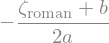

In [16]:
x_argmax_ = sp.solve(y_dx_, x)[0]
x_argmax_

In [19]:
param_names = ('a', 'b', 'c', 'zeta')
get_params = lambda param_names, **kw: tuple(kw[name] for name in param_names)
sp_params = tuple(globals()[name] for name in param_names)
sp_params

## Lambdify the symbolic functions

In [24]:
get_x_argmax = sp.lambdify(sp_params, x_argmax_, 'numpy', dummify=True)
get_y = sp.lambdify(sp_params + (x,), y_, 'numpy', dummify=True)

## Define derived functions

In [33]:
def get_y_max(*args):
    x = get_x_argmax(*args)
    return get_y(*args + (x,))

In [34]:
param_dict = dict(a=1,b=2,c=3,zeta=4)

In [35]:
get_y_max(1,2,3,4)

In [36]:
get_y_max(*get_params(param_names,**param_dict))

In [ ]:
get_x_argmax(3,4,5,6)

## Define data arrays and domains

In [ ]:
import numpy as np
x_arr = np.linspace(-8,8,100)

In [ ]:
import matplotlib.pylab as plt

In [ ]:
plt.plot(x_arr, get_y(1,2,3,4,x_arr));
plt.plot([get_x_argmax(1,2,3,4)], [get_y_max(1,2,3,4)], 'o' );

In [ ]:
get_y(*get_params(param_names, a=1,b=2,c=3,zeta=4)+(3,))

In [ ]:
import traits.api as tr
import ipywidgets as ipw

In [ ]:
class IModel(tr.Interface):
    '''Base class for interactive models'''

class ModelInteract(tr.HasStrictTraits):
    '''Model showing the max of the quadratic function'''

    model = tr.Instance(IModel)
    
    def ipw_interact(self):
        sliders = self.get_sliders()
        out = ipw.interactive_output(self.update_fields, sliders);
        self.widget_layout(out, sliders)

    n_steps = tr.Int(20)
    
    def get_sliders(self):
        param_names = self.model.param_names
        traits = self.model.traits(param=True)
        vals = self.model.trait_get(param=True)
        val_ = [vals[name] for name in param_names]
        minmax_ = [getattr(traits[name],'minmax', 2) for name in param_names]
        latex_ = [getattr(traits[name],'latex', r'<none>') for name in param_names]
        return {name : ipw.FloatSlider(
            value=val, min=minmax[0], max=minmax[1],
            step=(minmax[1]-minmax[0]) / self.n_steps,
            description=r'\(%s\)' % latex)
            for (name, val, latex, minmax) in 
                zip(param_names, val_, latex_, minmax_)
        }

    def update_fields(self, **values):
        self.model.trait_set(**values)
        print(values)

    def widget_layout(self, out, sliders):
        layout = ipw.Layout(grid_template_columns='1fr 1fr')
        param_sliders_list = [sliders[name] for name in param_names]
        grid = ipw.GridBox(param_sliders_list, layout=layout)
        box = ipw.VBox([grid, out])
        display(box)

In [ ]:
@tr.provides(IModel)
class QuadEq(tr.HasTraits):
    a = tr.Float(3, param=True, latex='a', minmax=(-8,8))
    b = tr.Float(3, param=True, latex='b', minmax=(-8,8))
    c = tr.Float(3, param=True, latex='c', minmax=(-8,8))
    zeta = tr.Float(3, param=True, latex=r'\zeta', minmax=(-8,8))
    param_names = param_names

In [ ]:
qei = ModelInteract(model=QuadEq())

qei.ipw_interact()

In [37]:
## Define data arrays and domains

## Define data arrays and domains

In [38]:
import numpy as np
x_arr = np.linspace(-8,8,100)

In [39]:
import matplotlib.pylab as plt

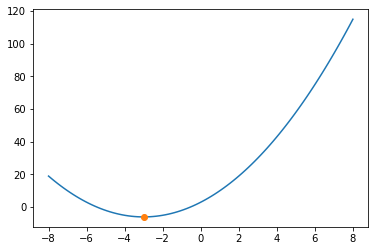

In [43]:
plt.plot(x_arr, get_y(1,2,3,4,x_arr));
plt.plot([get_x_argmax(1,2,3,4)], [get_y_max(1,2,3,4)], 'o' );

In [ ]:
get_y(*get_params(param_names, a=1,b=2,c=3,zeta=4)+(3,))

In [45]:
import traits.api as tr
import ipywidgets as ipw

In [46]:
class IModel(tr.Interface):
    '''Base class for interactive models'''

class ModelInteract(tr.HasStrictTraits):
    '''Model showing the max of the quadratic function'''

    model = tr.Instance(IModel)
    
    def ipw_interact(self):
        sliders = self.get_sliders()
        out = ipw.interactive_output(self.update_fields, sliders);
        self.widget_layout(out, sliders)

    n_steps = tr.Int(20)
    
    def get_sliders(self):
        param_names = self.model.param_names
        traits = self.model.traits(param=True)
        vals = self.model.trait_get(param=True)
        val_ = [vals[name] for name in param_names]
        minmax_ = [getattr(traits[name],'minmax', 2) for name in param_names]
        latex_ = [getattr(traits[name],'latex', r'<none>') for name in param_names]
        return {name : ipw.FloatSlider(
            value=val, min=minmax[0], max=minmax[1],
            step=(minmax[1]-minmax[0]) / self.n_steps,
            description=r'\(%s\)' % latex)
            for (name, val, latex, minmax) in 
                zip(param_names, val_, latex_, minmax_)
        }

    def update_fields(self, **values):
        self.model.trait_set(**values)
        print(values)

    def widget_layout(self, out, sliders):
        layout = ipw.Layout(grid_template_columns='1fr 1fr')
        param_sliders_list = [sliders[name] for name in param_names]
        grid = ipw.GridBox(param_sliders_list, layout=layout)
        box = ipw.VBox([grid, out])
        display(box)

In [47]:
@tr.provides(IModel)
class QuadEq(tr.HasTraits):
    a = tr.Float(3, param=True, latex='a', minmax=(-8,8))
    b = tr.Float(3, param=True, latex='b', minmax=(-8,8))
    c = tr.Float(3, param=True, latex='c', minmax=(-8,8))
    zeta = tr.Float(3, param=True, latex=r'\zeta', minmax=(-8,8))
    param_names = param_names

In [48]:
qei = ModelInteract(model=QuadEq())

qei.ipw_interact()

## Define data arrays and domains

In [ ]:
import numpy as np
x_arr = np.linspace(-8,8,100)

In [ ]:
import matplotlib.pylab as plt

In [ ]:
plt.plot(x_arr, get_y(1,2,3,4,x_arr));

In [ ]:
get_y(*get_params(param_names, a=1,b=2,c=3,zeta=4)+(3,))

In [ ]:
import traits.api as tr
import ipywidgets as ipw

In [ ]:
class IModel(tr.Interface):
    '''Base class for interactive models'''

class ModelInteract(tr.HasStrictTraits):
    '''Model showing the max of the quadratic function'''

    model = tr.Instance(IModel)
    
    def ipw_interact(self):
        sliders = self.get_sliders()
        out = ipw.interactive_output(self.update_fields, sliders);
        self.widget_layout(out, sliders)

    n_steps = tr.Int(20)
    
    def get_sliders(self):
        param_names = self.model.param_names
        traits = self.model.traits(param=True)
        vals = self.model.trait_get(param=True)
        val_ = [vals[name] for name in param_names]
        minmax_ = [getattr(traits[name],'minmax', 2) for name in param_names]
        latex_ = [getattr(traits[name],'latex', r'<none>') for name in param_names]
        return {name : ipw.FloatSlider(
            value=val, min=minmax[0], max=minmax[1],
            step=(minmax[1]-minmax[0]) / self.n_steps,
            description=r'\(%s\)' % latex)
            for (name, val, latex, minmax) in 
                zip(param_names, val_, latex_, minmax_)
        }

    def update_fields(self, **values):
        self.model.trait_set(**values)
        print(values)

    def widget_layout(self, out, sliders):
        layout = ipw.Layout(grid_template_columns='1fr 1fr')
        param_sliders_list = [sliders[name] for name in param_names]
        grid = ipw.GridBox(param_sliders_list, layout=layout)
        box = ipw.VBox([grid, out])
        display(box)

In [ ]:
@tr.provides(IModel)
class QuadEq(tr.HasTraits):
    a = tr.Float(3, param=True, latex='a', minmax=(-8,8))
    b = tr.Float(3, param=True, latex='b', minmax=(-8,8))
    c = tr.Float(3, param=True, latex='c', minmax=(-8,8))
    zeta = tr.Float(3, param=True, latex=r'\zeta', minmax=(-8,8))
    param_names = param_names

In [ ]:
qei = ModelInteract(model=QuadEq())

qei.ipw_interact()